In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 11 19:49:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |  12035MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime
import logging

In [ ]:
#logging 

# create run_lof folder if not exist
if not os.path.exists('/content/drive/MyDrive/DLCV_CW3/run_logs/'):
    os.mkdir('/content/drive/MyDrive/DLCV_CW3/run_logs/')


Log_Format = "%(levelname)s %(asctime)s - %(message)s"

logging.basicConfig(filename = "/content/drive/MyDrive/DLCV_CW3/run_logs/googlenet_"+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+".log",
                    filemode = "w",
                    format = Log_Format, 
                    level = logging.ERROR)


logger = logging.getLogger()

logger.setLevel(logging.INFO)

# Load and normalize MNIST

In [ ]:
logger.info("Loading MNIST dataset") 

mnist_data_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_data/'
mnist_save_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_GOOGLENET_results/'
mnist_fig_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_GOOGLENET_figures/'

# create folder if not exist
if not os.path.exists(mnist_save_dir):
    os.mkdir(mnist_save_dir)

if not os.path.exists(mnist_fig_dir):
    os.mkdir(mnist_fig_dir)

In [ ]:
logger.info("Transforming MNIST dataset") 

mnist_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


mnist_train_data = datasets.MNIST(root=mnist_data_dir, train=True, transform=mnist_transform, download=True)

val_size = int(len(mnist_train_data) * 0.2)
train_size = len(mnist_train_data) - val_size

mnist_train_data, mnist_val_data = random_split(mnist_train_data, [train_size, val_size])
mnist_train_loader = DataLoader(dataset=mnist_train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

mnist_val_loader = DataLoader(dataset=mnist_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

mnist_test_data = datasets.MNIST(root=mnist_data_dir, train=False, transform=mnist_transform, download=True)
mnist_test_loader = DataLoader(dataset=mnist_test_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

# Visualising the MNIST data 

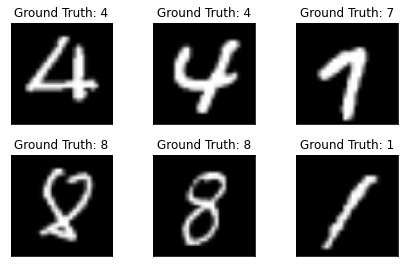

In [ ]:
logger.info("Visualising MNIST dataset") 

examples = enumerate(mnist_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


# Load and normalize CIFAR10


In [ ]:
logger.info("Loading Cifar dataset") 

cifar_data_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_data/'
cifar_save_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_GOOGLENET_results/'
cifar_fig_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_GOOGLENET_figures/'

# create folder if not exist
if not os.path.exists(cifar_save_dir):
    os.mkdir(cifar_save_dir)

if not os.path.exists(cifar_fig_dir):
    os.mkdir(cifar_fig_dir)

In [ ]:
logger.info("Transforming CIFAR dataset") 

cifar_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


cifar_train_data = datasets.CIFAR10(root=cifar_data_dir, train=True, transform=cifar_transform, download=True)

val_size = int(len(cifar_train_data) * 0.2)
train_size = len(cifar_train_data) - val_size

cifar_train_data, cifar_val_data = random_split(cifar_train_data, [train_size, val_size])
cifar_train_loader = DataLoader(dataset = cifar_train_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_val_loader = DataLoader(dataset = cifar_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_test_data = datasets.CIFAR10(root=cifar_data_dir, train=False, transform=cifar_transform)
cifar_test_loader = DataLoader(dataset = cifar_test_data, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)

cifar_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


# Visualising the CIFAR data 

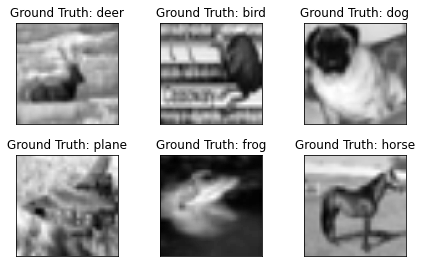

In [ ]:
logger.info("Visualising CIFAR dataset") 

examples = enumerate(cifar_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(cifar_classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])


# GoogleNET Model Class

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    # Forward propagation function
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool1(x)       
        x = self.conv2(x)       
        x = self.conv3(x)       
        x = self.maxpool2(x)

        
        x = self.inception3a(x)       
        x = self.inception3b(x)
        x = self.maxpool3(x)      
        x = self.inception4a(x)
        
        if self.training and self.aux_logits:    
            aux1 = self.aux1(x)

        x = self.inception4b(x)       
        x = self.inception4c(x)       
        x = self.inception4d(x)
        
        if self.training and self.aux_logits:    
            aux2 = self.aux2(x)

        x = self.inception4e(x)       
        x = self.maxpool4(x)       
        x = self.inception5a(x)       
        x = self.inception5b(x)
      

        x = self.avgpool(x)        
        x = torch.flatten(x, 1)      
        x = self.dropout(x)
        x = self.fc(x)
        
        if self.training and self.aux_logits:   
            return x, aux2, aux1
        return x

    # Weight initialization 
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Build Inception
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    # propagation function
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

 
    def forward(self, x):
        
        x = self.averagePool(x)       
        x = self.conv(x)       
        x = torch.flatten(x, 1)
        x = nn.functional.dropout(x, 0.5, training=self.training)        
        x = nn.functional.relu(self.fc1(x), inplace=True)
        x = nn.functional.dropout(x, 0.5, training=self.training)        
        x = self.fc2(x)
        
        return x

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


In [ ]:
model = GoogLeNet()
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (branch2): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), paddin

# Model Training Base Code 

In [ ]:
def train_model(model, model_log_path, train_loader, val_loader, loss_function, optimizer):
    
    writer = SummaryWriter(model_log_path)

    
    epochs = 10

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  
    model = model.to(device)


    # tracking variables
    train_hist = {}
    train_hist['model_train_losses'] = []
    train_hist['model_val_losses'] = []
    train_hist['model_val_accuracies'] = []
    train_hist['model_per_epoch_ptimes'] = []
    train_hist['model_total_ptime'] = []


    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        loss_train = []    
        epoch_start_time = time.time()
        for (image, target) in tqdm(train_loader):
            image = image.to(device)

            target = target.to(device)

            ## Forward Pass
            model_optimizer.zero_grad()
            logits, aux_logits2, aux_logits1 = model(image.to(device))
            _, predictions = torch.max(logits, dim=1)
            loss0 = loss_function(logits, target.to(device))
            loss1 = loss_function(aux_logits1, target.to(device))
            loss2 = loss_function(aux_logits2, target.to(device))
            loss = loss0 + loss1 * 0.3 + loss2 * 0.3
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())

        val_accuracy = 0
        val_loss = []
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for (image, target) in tqdm(val_loader):
                image = image.to(device)

                target = target.to(device)
                
                logits, aux_logits2, aux_logits1 = model(image.to(device))
                _, predictions = torch.max(logits, dim=1)
                loss0 = loss_function(logits, target.to(device)).item()
                loss1 = loss_function(aux_logits1, target.to(device)).item()
                loss2 = loss_function(aux_logits2, target.to(device)).item()
                loss = loss0 + loss1 * 0.3 + loss2 * 0.3
                num_correct += (predictions == target.to(device)).sum()
                num_samples += predictions.size(0)
                val_loss.append(loss)
            val_accuracy = float(num_correct) / float(num_samples)

        epoch_loss_train = np.mean(loss_train)
        epoch_val_loss = np.mean(val_loss)
        epoch_val_accuracy = val_accuracy
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        print("Training loss: %.8f, Validation loss: %.8f, Validation Accuracies: %.8f " % (epoch_loss_train, epoch_val_loss, epoch_val_accuracy))

        # record the loss for every epoch
        train_hist['model_train_losses'].append(epoch_loss_train)
        train_hist['model_val_losses'].append(epoch_val_loss)
        train_hist['model_val_accuracies'].append(epoch_val_accuracy)
        train_hist['model_per_epoch_ptimes'].append(per_epoch_ptime)
        
        writer.add_scalar("Loss/train", epoch_loss_train, epoch)
        writer.add_scalar("Loss/Val", epoch_val_loss, epoch)
        writer.add_scalar("Accuracy/val", epoch_val_accuracy, epoch)


    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['model_total_ptime'].append(total_ptime)
    
    writer.flush()
    
    writer.close()

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['model_per_epoch_ptimes']), epochs, total_ptime))
    
    
    return model, train_hist

In [ ]:
def test_model(model, test_loader, loss_function):
    

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
    with torch.no_grad():
        num_correct = 0
        num_samples = 0

        test_loss = []

        for (image, target) in tqdm(test_loader):
            image = image.to(device)

            target = target.to(device)
        
            logits, aux_logits2, aux_logits1 = model(image.to(device))
            _, predictions = torch.max(logits, dim=1)
            loss0 = loss_function(logits, target.to(device)).item()
            loss1 = loss_function(aux_logits1, target.to(device)).item()
            loss2 = loss_function(aux_logits2, target.to(device)).item()
            loss = loss0 + loss1 * 0.3 + loss2 * 0.3

            num_correct += (predictions == target.to(device)).sum()
            num_samples += predictions.size(0)

            test_loss.append(loss)

        test_accuracy = float(num_correct) / float(num_samples)
        avg_test_loss = np.mean(test_loss)

        print("Testing loss: %.8f, Testing Accuracies: %.8f " % (avg_test_loss, test_accuracy))

    return test_loss


# Training MNSIT dataset on GoogLeNet

11-05-2022-20-15-41
Training GoogLeNet on mnist with lr=0.0001 optimizer= Adam


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 188/188 [00:08<00:00, 22.56it/s]


Epoch 1 of 10 with 116.43 s
Training loss: 1.62443616, Validation loss: 0.37553265, Validation Accuracies: 0.92175000 


100%|██████████| 188/188 [00:08<00:00, 22.60it/s]


Epoch 2 of 10 with 116.49 s
Training loss: 0.29269416, Validation loss: 0.21228076, Validation Accuracies: 0.96066667 


100%|██████████| 188/188 [00:08<00:00, 22.55it/s]


Epoch 3 of 10 with 116.49 s
Training loss: 0.18030040, Validation loss: 0.14923560, Validation Accuracies: 0.97175000 


100%|██████████| 188/188 [00:08<00:00, 22.50it/s]


Epoch 4 of 10 with 116.51 s
Training loss: 0.13858228, Validation loss: 0.12502731, Validation Accuracies: 0.97700000 


100%|██████████| 188/188 [00:08<00:00, 22.53it/s]


Epoch 5 of 10 with 116.54 s
Training loss: 0.10970264, Validation loss: 0.09660376, Validation Accuracies: 0.98375000 


100%|██████████| 188/188 [00:08<00:00, 22.49it/s]


Epoch 6 of 10 with 116.53 s
Training loss: 0.09355805, Validation loss: 0.08237531, Validation Accuracies: 0.98616667 


100%|██████████| 188/188 [00:08<00:00, 22.54it/s]


Epoch 7 of 10 with 116.56 s
Training loss: 0.07872883, Validation loss: 0.07099434, Validation Accuracies: 0.98875000 


100%|██████████| 188/188 [00:08<00:00, 22.58it/s]


Epoch 8 of 10 with 116.52 s
Training loss: 0.07169451, Validation loss: 0.07713167, Validation Accuracies: 0.98608333 


100%|██████████| 188/188 [00:08<00:00, 22.60it/s]


Epoch 9 of 10 with 116.52 s
Training loss: 0.06001366, Validation loss: 0.06807785, Validation Accuracies: 0.98941667 


100%|██████████| 188/188 [00:08<00:00, 22.52it/s]


Epoch 10 of 10 with 116.55 s
Training loss: 0.05598925, Validation loss: 0.06683471, Validation Accuracies: 0.98975000 
Avg per epoch ptime: 116.51, total 10 epochs ptime: 1165.17
Training finish!... save and plotting training results


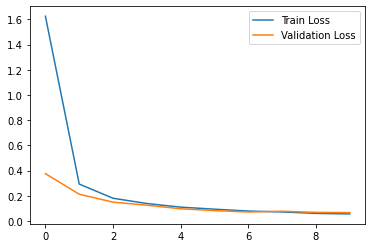

Testing GoogLeNet trained model


100%|██████████| 157/157 [00:07<00:00, 22.40it/s]


Testing loss: 0.05580226, Testing Accuracies: 0.99080000 
Testing finish!... plotting testing results


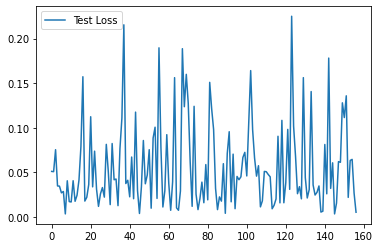

Training GoogLeNet on mnist with lr=0.0001 optimizer= SGD


100%|██████████| 188/188 [00:08<00:00, 22.53it/s]


Epoch 1 of 10 with 114.28 s
Training loss: 3.68403033, Validation loss: 3.68395291, Validation Accuracies: 0.10225000 


100%|██████████| 188/188 [00:08<00:00, 22.53it/s]


Epoch 2 of 10 with 114.29 s
Training loss: 3.68409021, Validation loss: 3.68401103, Validation Accuracies: 0.09966667 


100%|██████████| 188/188 [00:08<00:00, 22.54it/s]


Epoch 3 of 10 with 114.30 s
Training loss: 3.68405248, Validation loss: 3.68411167, Validation Accuracies: 0.09858333 


100%|██████████| 188/188 [00:08<00:00, 22.55it/s]


Epoch 4 of 10 with 114.32 s
Training loss: 3.68398209, Validation loss: 3.68390756, Validation Accuracies: 0.10258333 


100%|██████████| 188/188 [00:08<00:00, 22.57it/s]


Epoch 5 of 10 with 114.25 s
Training loss: 3.68402217, Validation loss: 3.68379846, Validation Accuracies: 0.10216667 


100%|██████████| 188/188 [00:08<00:00, 22.54it/s]


Epoch 6 of 10 with 114.34 s
Training loss: 3.68396168, Validation loss: 3.68393464, Validation Accuracies: 0.09866667 


100%|██████████| 188/188 [00:08<00:00, 22.47it/s]


Epoch 7 of 10 with 114.33 s
Training loss: 3.68393263, Validation loss: 3.68396419, Validation Accuracies: 0.09858333 


100%|██████████| 188/188 [00:08<00:00, 22.59it/s]


Epoch 8 of 10 with 114.28 s
Training loss: 3.68380613, Validation loss: 3.68381097, Validation Accuracies: 0.10175000 


100%|██████████| 188/188 [00:08<00:00, 22.53it/s]


Epoch 9 of 10 with 114.28 s
Training loss: 3.68384020, Validation loss: 3.68371680, Validation Accuracies: 0.10458333 


100%|██████████| 188/188 [00:08<00:00, 22.57it/s]


Epoch 10 of 10 with 114.29 s
Training loss: 3.68383516, Validation loss: 3.68373841, Validation Accuracies: 0.10441667 
Avg per epoch ptime: 114.30, total 10 epochs ptime: 1142.98
Training finish!... save and plotting training results


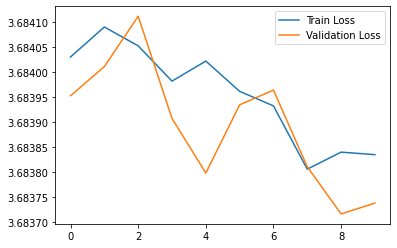

Testing GoogLeNet trained model


100%|██████████| 157/157 [00:07<00:00, 22.36it/s]


Testing loss: 3.68385776, Testing Accuracies: 0.10200000 
Testing finish!... plotting testing results


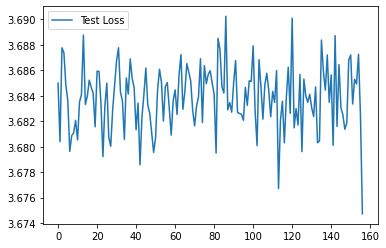

Training GoogLeNet on mnist with lr=0.01 optimizer= Adam


100%|██████████| 188/188 [00:08<00:00, 22.59it/s]


Epoch 1 of 10 with 116.34 s
Training loss: 36.13552406, Validation loss: 3.68182164, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.62it/s]


Epoch 2 of 10 with 116.45 s
Training loss: 3.68348222, Validation loss: 3.68294142, Validation Accuracies: 0.10408333 


100%|██████████| 188/188 [00:08<00:00, 22.58it/s]


Epoch 3 of 10 with 116.48 s
Training loss: 3.68366834, Validation loss: 3.68249191, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.52it/s]


Epoch 4 of 10 with 116.47 s
Training loss: 3.68362408, Validation loss: 3.68178910, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.44it/s]


Epoch 5 of 10 with 116.50 s
Training loss: 3.68338293, Validation loss: 3.68378028, Validation Accuracies: 0.10408333 


100%|██████████| 188/188 [00:08<00:00, 22.58it/s]


Epoch 6 of 10 with 116.45 s
Training loss: 3.68358975, Validation loss: 3.68267424, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.57it/s]


Epoch 7 of 10 with 116.42 s
Training loss: 3.68373295, Validation loss: 3.68221822, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.53it/s]


Epoch 8 of 10 with 116.48 s
Training loss: 3.68356504, Validation loss: 3.68425175, Validation Accuracies: 0.09866667 


100%|██████████| 188/188 [00:08<00:00, 22.46it/s]


Epoch 9 of 10 with 116.47 s
Training loss: 3.68370970, Validation loss: 3.68284710, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.56it/s]


Epoch 10 of 10 with 116.45 s
Training loss: 3.68348969, Validation loss: 3.68259363, Validation Accuracies: 0.11225000 
Avg per epoch ptime: 116.45, total 10 epochs ptime: 1164.52
Training finish!... save and plotting training results


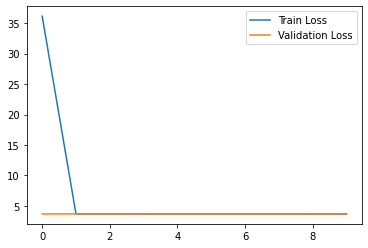

Testing GoogLeNet trained model


100%|██████████| 157/157 [00:07<00:00, 22.36it/s]


Testing loss: 3.68344291, Testing Accuracies: 0.11350000 
Testing finish!... plotting testing results


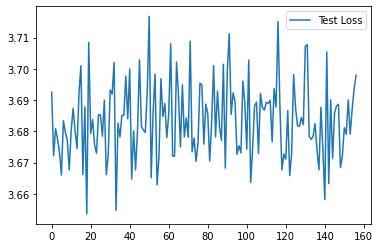

Training GoogLeNet on mnist with lr=0.01 optimizer= SGD


100%|██████████| 188/188 [00:08<00:00, 22.50it/s]


Epoch 1 of 10 with 114.37 s
Training loss: 3.68359279, Validation loss: 3.68257410, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.55it/s]


Epoch 2 of 10 with 114.32 s
Training loss: 3.68264160, Validation loss: 3.68199967, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.58it/s]


Epoch 3 of 10 with 114.29 s
Training loss: 3.68233545, Validation loss: 3.68191422, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.52it/s]


Epoch 4 of 10 with 114.31 s
Training loss: 3.68214855, Validation loss: 3.68175938, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.54it/s]


Epoch 5 of 10 with 114.33 s
Training loss: 3.68217127, Validation loss: 3.68178058, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.46it/s]


Epoch 6 of 10 with 114.32 s
Training loss: 3.68215843, Validation loss: 3.68167840, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.60it/s]


Epoch 7 of 10 with 114.33 s
Training loss: 3.68213945, Validation loss: 3.68174158, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.48it/s]


Epoch 8 of 10 with 114.37 s
Training loss: 3.68210788, Validation loss: 3.68172503, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.47it/s]


Epoch 9 of 10 with 114.40 s
Training loss: 3.68206018, Validation loss: 3.68162225, Validation Accuracies: 0.11225000 


100%|██████████| 188/188 [00:08<00:00, 22.54it/s]


Epoch 10 of 10 with 114.35 s
Training loss: 3.68205954, Validation loss: 3.68156576, Validation Accuracies: 0.11225000 
Avg per epoch ptime: 114.34, total 10 epochs ptime: 1143.41
Training finish!... save and plotting training results


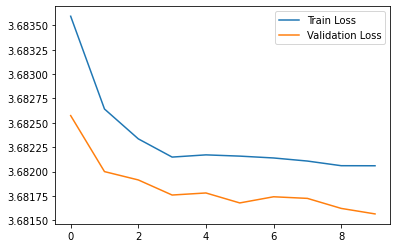

Testing GoogLeNet trained model


100%|██████████| 157/157 [00:07<00:00, 22.29it/s]


Testing loss: 3.68139583, Testing Accuracies: 0.11350000 
Testing finish!... plotting testing results


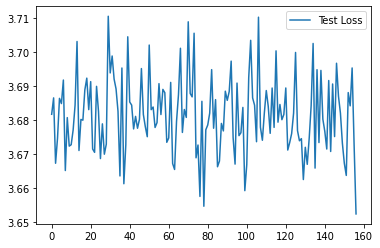

In [ ]:
logger.info("Training GoogLeNet on MNIST dataset") 
print(datetime.today().strftime('%d-%m-%Y-%H-%M-%S'))

for lr in [0.0001, 0.01]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(mnist_save_dir+"/GoogLeNet_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
            print("Already trained on GoogLeNet on mnist with lr={} optimizer= {}".format(lr,optimizer))
  

        else:
            model = GoogLeNet()
            #model.eval()

            if optimizer == 'Adam':
                model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            if optimizer == 'SGD':
                model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            print("Training GoogLeNet on mnist with lr={} optimizer= {}".format(lr,optimizer))
          
            model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/mnist_GoogLeNet_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

            trained_model, train_hist = train_model(model, model_log_path, mnist_train_loader, mnist_val_loader, criterion, model_optimizer)
            
            print("Training finish!... save and plotting training results")

            with open(mnist_save_dir +'train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
                pickle.dump(train_hist, f)

            logger.info("Saving GoogLeNet trained model on  MNIST dataset") 
            torch.save(model.state_dict(), mnist_save_dir+"/GoogLeNet_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

            logger.info("Plotting RESNET Model train losses on MNIST") 

            plt.plot(train_hist['model_train_losses'])
            plt.plot(train_hist['model_val_losses'])
            plt.legend(["Train Loss", "Validation Loss"])
            plt.savefig(mnist_fig_dir + "/GoogLeNet_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()    

            print("Testing GoogLeNet trained model")
            test_loss = test_model(model, mnist_test_loader, criterion)
            print("Testing finish!... plotting testing results")
            plt.plot(test_loss)
            plt.legend(["Test Loss"])
            plt.savefig(mnist_fig_dir + "/GoogleNet_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()
        print("========================================================")



# Training CIFAR 10 dataset on GoogleNet

11-05-2022-21-33-08
Training GoogLeNet on cifar10 with lr=0.0001 optimizer= Adam


  0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 157/157 [00:07<00:00, 22.11it/s]


Epoch 1 of 10 with 97.25 s
Training loss: 3.38261656, Validation loss: 3.10973769, Validation Accuracies: 0.28280000 


100%|██████████| 157/157 [00:07<00:00, 22.05it/s]


Epoch 2 of 10 with 97.37 s
Training loss: 2.85950492, Validation loss: 2.74118493, Validation Accuracies: 0.36680000 


100%|██████████| 157/157 [00:07<00:00, 22.04it/s]


Epoch 3 of 10 with 97.40 s
Training loss: 2.57695994, Validation loss: 2.54909277, Validation Accuracies: 0.41090000 


100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


Epoch 4 of 10 with 97.40 s
Training loss: 2.38179155, Validation loss: 2.35632269, Validation Accuracies: 0.46230000 


100%|██████████| 157/157 [00:07<00:00, 21.97it/s]


Epoch 5 of 10 with 97.45 s
Training loss: 2.21379774, Validation loss: 2.17087046, Validation Accuracies: 0.52370000 


100%|██████████| 157/157 [00:07<00:00, 22.05it/s]


Epoch 6 of 10 with 97.41 s
Training loss: 2.08201640, Validation loss: 2.05909853, Validation Accuracies: 0.55430000 


100%|██████████| 157/157 [00:07<00:00, 22.19it/s]


Epoch 7 of 10 with 97.37 s
Training loss: 1.95703410, Validation loss: 2.02220773, Validation Accuracies: 0.57270000 


100%|██████████| 157/157 [00:07<00:00, 22.02it/s]


Epoch 8 of 10 with 97.45 s
Training loss: 1.85093260, Validation loss: 1.88882675, Validation Accuracies: 0.60430000 


100%|██████████| 157/157 [00:07<00:00, 22.14it/s]


Epoch 9 of 10 with 97.43 s
Training loss: 1.75721755, Validation loss: 1.82017584, Validation Accuracies: 0.60870000 


100%|██████████| 157/157 [00:07<00:00, 21.99it/s]


Epoch 10 of 10 with 97.48 s
Training loss: 1.67152619, Validation loss: 1.89123769, Validation Accuracies: 0.61060000 
Avg per epoch ptime: 97.40, total 10 epochs ptime: 974.02
Training finish!... save and plotting training results


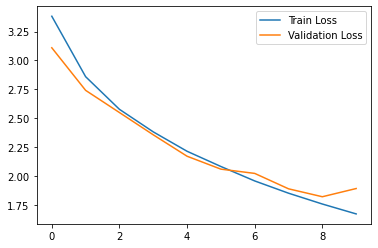

Testing VGG trained model


100%|██████████| 157/157 [00:07<00:00, 21.95it/s]


Testing loss: 1.84465259, Testing Accuracies: 0.61690000 
Testing finish!... plotting testing results


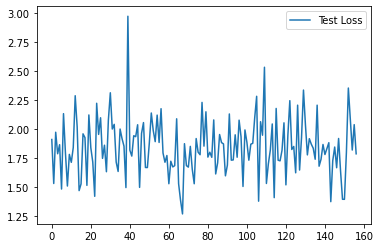

Training GoogLeNet on cifar10 with lr=0.0001 optimizer= SGD


100%|██████████| 157/157 [00:07<00:00, 22.05it/s]


Epoch 1 of 10 with 95.52 s
Training loss: 3.68446562, Validation loss: 3.68421300, Validation Accuracies: 0.10300000 


100%|██████████| 157/157 [00:07<00:00, 22.00it/s]


Epoch 2 of 10 with 95.53 s
Training loss: 3.68451476, Validation loss: 3.68423122, Validation Accuracies: 0.09810000 


100%|██████████| 157/157 [00:07<00:00, 22.02it/s]


Epoch 3 of 10 with 95.52 s
Training loss: 3.68436964, Validation loss: 3.68428305, Validation Accuracies: 0.10290000 


100%|██████████| 157/157 [00:07<00:00, 22.15it/s]


Epoch 4 of 10 with 95.51 s
Training loss: 3.68447288, Validation loss: 3.68424160, Validation Accuracies: 0.10320000 


100%|██████████| 157/157 [00:07<00:00, 22.16it/s]


Epoch 5 of 10 with 95.47 s
Training loss: 3.68443477, Validation loss: 3.68428651, Validation Accuracies: 0.09960000 


100%|██████████| 157/157 [00:07<00:00, 22.10it/s]


Epoch 6 of 10 with 95.50 s
Training loss: 3.68447842, Validation loss: 3.68417648, Validation Accuracies: 0.10190000 


100%|██████████| 157/157 [00:07<00:00, 22.09it/s]


Epoch 7 of 10 with 95.50 s
Training loss: 3.68441684, Validation loss: 3.68406560, Validation Accuracies: 0.09870000 


100%|██████████| 157/157 [00:07<00:00, 22.12it/s]


Epoch 8 of 10 with 95.51 s
Training loss: 3.68446253, Validation loss: 3.68432178, Validation Accuracies: 0.10050000 


100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


Epoch 9 of 10 with 95.51 s
Training loss: 3.68446721, Validation loss: 3.68416922, Validation Accuracies: 0.10540000 


100%|██████████| 157/157 [00:07<00:00, 22.03it/s]


Epoch 10 of 10 with 95.51 s
Training loss: 3.68436505, Validation loss: 3.68427140, Validation Accuracies: 0.10010000 
Avg per epoch ptime: 95.51, total 10 epochs ptime: 955.09
Training finish!... save and plotting training results


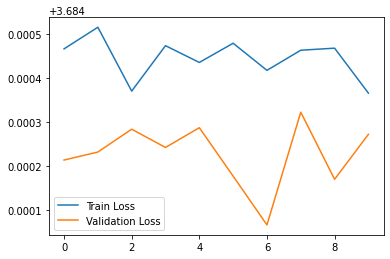

Testing VGG trained model


100%|██████████| 157/157 [00:07<00:00, 22.01it/s]


Testing loss: 3.68435370, Testing Accuracies: 0.09960000 
Testing finish!... plotting testing results


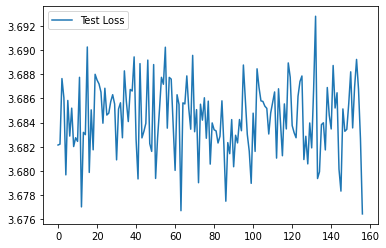

Training GoogLeNet on cifar10 with lr=0.01 optimizer= Adam


100%|██████████| 157/157 [00:07<00:00, 22.19it/s]


Epoch 1 of 10 with 97.21 s
Training loss: 68.29237068, Validation loss: 3.68566808, Validation Accuracies: 0.09780000 


100%|██████████| 157/157 [00:07<00:00, 22.02it/s]


Epoch 2 of 10 with 97.33 s
Training loss: 3.68538542, Validation loss: 3.68629193, Validation Accuracies: 0.09550000 


100%|██████████| 157/157 [00:07<00:00, 22.00it/s]


Epoch 3 of 10 with 97.36 s
Training loss: 3.68554364, Validation loss: 3.68473235, Validation Accuracies: 0.09980000 


100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


Epoch 4 of 10 with 97.32 s
Training loss: 3.68551188, Validation loss: 3.68618186, Validation Accuracies: 0.10160000 


100%|██████████| 157/157 [00:07<00:00, 22.15it/s]


Epoch 5 of 10 with 97.29 s
Training loss: 3.68546307, Validation loss: 3.68637927, Validation Accuracies: 0.09780000 


100%|██████████| 157/157 [00:07<00:00, 22.10it/s]


Epoch 6 of 10 with 97.32 s
Training loss: 3.68566716, Validation loss: 3.68577632, Validation Accuracies: 0.10100000 


100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


Epoch 7 of 10 with 97.34 s
Training loss: 3.68586178, Validation loss: 3.68541240, Validation Accuracies: 0.10160000 


100%|██████████| 157/157 [00:07<00:00, 22.16it/s]


Epoch 8 of 10 with 97.30 s
Training loss: 3.68572295, Validation loss: 3.68483766, Validation Accuracies: 0.10160000 


100%|██████████| 157/157 [00:07<00:00, 22.16it/s]


Epoch 9 of 10 with 97.29 s
Training loss: 3.68576465, Validation loss: 3.68530309, Validation Accuracies: 0.09780000 


100%|██████████| 157/157 [00:07<00:00, 22.09it/s]


Epoch 10 of 10 with 97.31 s
Training loss: 3.68582468, Validation loss: 3.68405597, Validation Accuracies: 0.10670000 
Avg per epoch ptime: 97.31, total 10 epochs ptime: 973.07
Training finish!... save and plotting training results


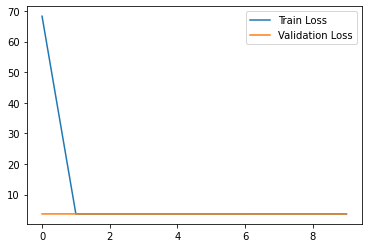

Testing VGG trained model


100%|██████████| 157/157 [00:07<00:00, 21.96it/s]


Testing loss: 3.68443856, Testing Accuracies: 0.10000000 
Testing finish!... plotting testing results


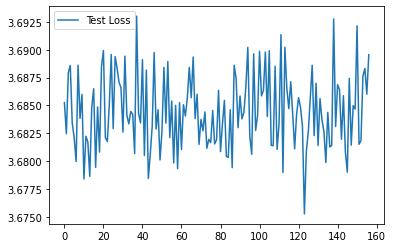

Training GoogLeNet on cifar10 with lr=0.01 optimizer= SGD


100%|██████████| 157/157 [00:07<00:00, 22.00it/s]


Epoch 1 of 10 with 95.62 s
Training loss: 3.68438766, Validation loss: 3.68451670, Validation Accuracies: 0.09810000 


100%|██████████| 157/157 [00:07<00:00, 21.99it/s]


Epoch 2 of 10 with 95.60 s
Training loss: 3.68430762, Validation loss: 3.68438998, Validation Accuracies: 0.10440000 


100%|██████████| 157/157 [00:07<00:00, 22.02it/s]


Epoch 3 of 10 with 95.58 s
Training loss: 3.68429996, Validation loss: 3.68437814, Validation Accuracies: 0.09600000 


100%|██████████| 157/157 [00:07<00:00, 21.92it/s]


Epoch 4 of 10 with 95.60 s
Training loss: 3.68427172, Validation loss: 3.68451051, Validation Accuracies: 0.09690000 


100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


Epoch 5 of 10 with 95.59 s
Training loss: 3.68427463, Validation loss: 3.68454019, Validation Accuracies: 0.09580000 


100%|██████████| 157/157 [00:07<00:00, 21.92it/s]


Epoch 6 of 10 with 95.57 s
Training loss: 3.68422132, Validation loss: 3.68447323, Validation Accuracies: 0.09880000 


100%|██████████| 157/157 [00:07<00:00, 22.11it/s]


Epoch 7 of 10 with 95.52 s
Training loss: 3.68422472, Validation loss: 3.68438070, Validation Accuracies: 0.09830000 


100%|██████████| 157/157 [00:07<00:00, 21.97it/s]


Epoch 8 of 10 with 95.59 s
Training loss: 3.68414545, Validation loss: 3.68456512, Validation Accuracies: 0.09740000 


100%|██████████| 157/157 [00:07<00:00, 22.02it/s]


Epoch 9 of 10 with 95.54 s
Training loss: 3.68421276, Validation loss: 3.68450355, Validation Accuracies: 0.09700000 


100%|██████████| 157/157 [00:07<00:00, 21.99it/s]


Epoch 10 of 10 with 95.60 s
Training loss: 3.68424011, Validation loss: 3.68445905, Validation Accuracies: 0.09750000 
Avg per epoch ptime: 95.58, total 10 epochs ptime: 955.83
Training finish!... save and plotting training results


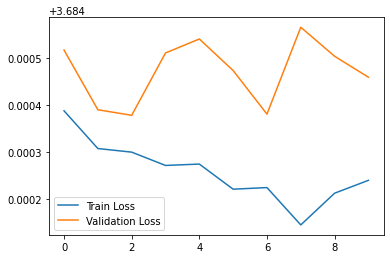

Testing VGG trained model


100%|██████████| 157/157 [00:07<00:00, 22.15it/s]


Testing loss: 3.68426550, Testing Accuracies: 0.10170000 
Testing finish!... plotting testing results


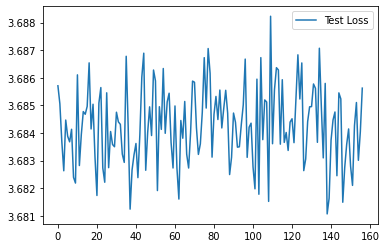

In [ ]:
logger.info("Trianing GoogLeNet on CIFAR dataset") 
print(datetime.today().strftime('%d-%m-%Y-%H-%M-%S'))

for lr in [0.0001, 0.01]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(mnist_save_dir+"/GoogLeNet_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
            print("Already trained GoogLeNet on cifar with lr={} optimizer= {}".format(lr,optimizer))
  

        else:
            model = GoogLeNet()
            #model.eval()

            if optimizer == 'Adam':
                model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            if optimizer == 'SGD':
                model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

          
            print("Training GoogLeNet on cifar10 with lr={} optimizer= {}".format(lr,optimizer))
          
            model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/cifar_GoogLeNet_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

            trained_model, train_hist = train_model(model, model_log_path, cifar_train_loader, cifar_val_loader, criterion, model_optimizer)
            
            print("Training finish!... save and plotting training results")

            with open(cifar_save_dir +'GoogLeNet_train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
                pickle.dump(train_hist, f)

            logger.info("Saving GoogLeNet trained model on CIFAR dataset") 
            torch.save(model.state_dict(), cifar_save_dir+"/GoogleNet_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

            logger.info("Plotting GoogLeNet Model train losses on CIFAR") 

            plt.plot(train_hist['model_train_losses'])
            plt.plot(train_hist['model_val_losses'])
            plt.legend(["Train Loss", "Validation Loss"])
            plt.savefig(cifar_fig_dir + "/GoogLeNet_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()

            print("Testing VGG trained model")
            test_loss = test_model(model, cifar_test_loader, criterion)
            print("Testing finish!... plotting testing results")
            plt.plot(test_loss)
            plt.legend(["Test Loss"])
            plt.savefig(cifar_fig_dir + "/GoogLeNet_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()
        print("========================================================")
